Implied Volatility (annual) for AAPL: 0.3940


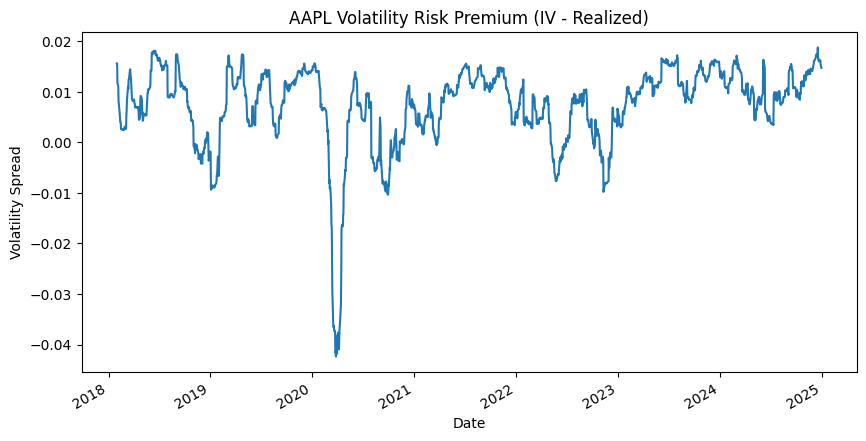

In [2]:
import sys, os
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import numpy as np

# Add the root directory (parent of notebooks/) to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), "..")) #os.getcwd() returns current working directory, ".." goes one level up

if project_root not in sys.path:

    # Look for modules in project_root
    sys.path.insert(0, project_root)


from src.volatility_factors import calculate_realized_volatility, iv_realized_diff
from src.options_utils import implied_volatility_call

# Load price data
prices = pd.read_csv("../data/processed/price_data.csv", index_col = 0, parse_dates = True)

# Calculate daily returns
returns = prices.pct_change().fillna(0)

# Calculate realized volatility (21 trading days)
realized_vol = calculate_realized_volatility(returns, ndays = 21)

# Using AAPL stock as a simple reference
ticker = "AAPL"
stock = yf.Ticker(ticker)

# Get nearest expiration option
options_dates = stock.options
near_exp = options_dates[0]
opt_chain = stock.option_chain(near_exp)

# Pick an ATM (At The Money) call
calls = opt_chain.calls
spot = stock.history(period="1d")['Close'].iloc[0]
atm_call = calls.iloc[(calls['strike'] - spot).abs().argsort()[:1]]


# Parameters (market price, strike price, time to maturity, drift rate and spot price) used in calculating implied volatility based on Black-Scholes
C_market = atm_call['lastPrice'].values[0]
K = atm_call['strike'].values[0]
T = (datetime.datetime.strptime(near_exp, "%Y-%m-%d") - datetime.datetime.today()).days / 365


# Fetch risk-free rate from Yahoo Finance (3-month T-bill rate)
t_bill = yf.Ticker("^IRX")
r = t_bill.history(period = "1d")['Close'].iloc[-1] / 100  # Convert to decimal
S = spot

# Calculate and print out implied volatility estimate, ideally a daily forward series calculated over ndays would be appropriate, but for simplicity, I calculate 1 value and clone it.
iv_estimate = implied_volatility_call(C_market, S, K, T, r)
print(f"Implied Volatility (annual) for {ticker}: {iv_estimate:.4f}")

# Convert implied volatility from annual to daily
iv_estimate = iv_estimate / (252 ** 0.5)

# Time series of implied volatility and volatility risk premium (VRP)
iv_series = pd.Series(iv_estimate, index = realized_vol.index)
vrp = iv_realized_diff(iv_series, realized_vol[ticker])

# Plot results
plt.figure(figsize = (10, 5))
vrp.plot(label = "AAPL Volatility Risk Premium")
plt.title("AAPL Volatility Risk Premium (IV - Realized)")
plt.ylabel("Volatility Spread")
plt.show()
